In [112]:
import cv2
import numpy as np
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import random
from math import floor, ceil

# Correspondences and Homography

In [113]:
def computeHomography(pairs):
    """
    Solves for the homography given any number of pairs of points. Visit
    http://6.869.csail.mit.edu/fa12/lectures/lecture13ransac/lecture13ransac.pdf
    slide 9 for more details.
    """
    A = []
    for x1, y1, x2, y2 in pairs:
        A.append([-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2])
    A = np.array(A)

    # Singular Value Decomposition (SVD)
    U, S, V = np.linalg.svd(A)

    # V has shape (9, 9) for any number of input pairs. V[-1] is the eigenvector
    # of (A^T)A with the smalles eigenvalue. Reshape into 3x3 matrix.
    H = np.reshape(V[-1], (3, 3))

    # Normalization
    H = (1 / H.item(8)) * H
    return H

In [114]:
def dist(pair, H):
    """ Returns the geometric distance between a pair of points given the
    homography H. """
    # points in homogeneous coordinates
    p1 = np.array([pair[0], pair[1], 1])
    p2 = np.array([pair[2], pair[3], 1])

    p2_estimate = np.dot(H, np.transpose(p1))
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    
    return np.linalg.norm(np.transpose(p2) - p2_estimate)

In [115]:
def RANSAC(point_map, threshold=0.6, verbose=True):
    if verbose: print(f'Running RANSAC with {len(point_map)} points...')
    bestInliers = set()
    homography = None
    for i in range(1000):
        # randomly choose 4 points from the matrix to compute the homography
        pairs = [point_map[i] for i in np.random.choice(len(point_map), 4)]

        H = computeHomography(pairs)
        inliers = {(c[0], c[1], c[2], c[3]) for c in point_map if dist(c, H) < 500}
        
        if verbose:
            print(f'\x1b[2K\r└──> iteration {i + 1}/{1000} ' + \
                  f'\t{len(inliers)} inlier' + ('s ' if len(inliers) != 1 else ' ') + \
                  f'\tbest: {len(bestInliers)}', end='')

        if len(inliers) > len(bestInliers):
            bestInliers = inliers
            homography = H
            if len(bestInliers) > (len(point_map) * threshold): break

    if verbose:
        print(f'\nNum matches: {len(point_map)}')
        print(f'Num inliers: {len(bestInliers)}')
        print(f'Min inliers: {len(point_map) * threshold}')

    return homography, bestInliers

In [116]:
def create2ImagePointMap(image_src, image_dst, matching_t=0.5, verbose=True):
    """
    Get the corresponding points from source and destination images
    params:
        img: the image
        video: list of frames from the video or a single frame
    returns:
        src_pts: the points from the image
        dst_pts: the points from the video
    """

    # sift = cv.xfeatures2d.SIFT_create()
    sift = cv2.SIFT_create()
    kp_dst, desc_dest = sift.detectAndCompute(image_dst, None)
    kp_src, desc_src = sift.detectAndCompute(image_src, None)

    matches = cv2.BFMatcher().knnMatch(desc_src,desc_dest,k=2)

    # Filter key points and keep good matches using certain threshhold
    goodMatches = []
    for m,n in matches:
        if m.distance < matching_t*n.distance:
            goodMatches.append(m)

    # Create source and destination point map from filtered matches
    point_map = np.array([
        [kp_src[m.queryIdx].pt[0],
        kp_src[m.queryIdx].pt[1],
        kp_dst[m.trainIdx].pt[0],
        kp_dst[m.trainIdx].pt[1]] for m in goodMatches
    ], dtype='float32')
    
    return point_map, goodMatches, kp_src, kp_dst

# Warping Image Planes

Creating frame to hold stitched image

In [132]:

def getWarpFrame(image_src, image_dst, shift):
    h_src, w_src = image_src.shape[:2]
    h_dst, w_dst = image_dst.shape[:2]
    
    warp_mask = np.zeros((max(h_src, h_dst), w_dst+shift, 3), dtype='uint8')
    warp_mask[:, shift:, :] = image_dst[:][:][:]

    return warp_mask


Warping source image to output frame

In [133]:
def warpImages(warp_frame, image_src, homography_mat, shift):
    warped_image = warp_frame.copy()
    for y in range(image_src.shape[0]):
        for x in range(image_src.shape[1]):
            p = np.array([x,y,1])
            p_dash = np.dot(homography_mat, p)
            x_dash, y_dash = (p_dash[0]/p_dash[2]), (p_dash[1]/p_dash[2])
            x_dash += shift
        
            x_floor, x_ceil, y_floor, y_ceil = floor(x_dash), ceil(x_dash), floor(y_dash), ceil(y_dash)
            y_ratio = y_dash - y_floor
            x_ratio = x_dash - x_floor

            neighbor_pixels = {
                'bot_left': [y_floor, x_floor],
                'top_left': [y_ceil, x_floor],
                'bot_right': [y_floor, x_ceil],
                'top_right': [y_ceil, x_ceil]
            }

            neighbor_weights = {
                'bot_left': (1-x_ratio)*(1-y_ratio),
                'top_left': ((1-x_ratio)*y_ratio),
                'bot_right': (x_ratio*(1-y_ratio)),
                'top_right':(x_ratio*y_ratio) 
            }
            
            if 0 < y_dash < warped_image.shape[0] and -shift < x_ceil-shift < warped_image.shape[1]:
                warped_image[int(y_dash), int(x_dash), :] = image_src[y, x, :]
                # for pixel in neighbor_pixels:
                #     f = np.zeros((3), dtype='uint8')                                                                                                                                                                                                                
                #     for i in range(3):
                #         if warp_mask2[neighbor_pixels[pixel][0], neighbor_pixels[pixel][1], i] == 0:
                #             f[i] = neighbor_weights[pixel] * image_src[y, x, i]
                #         else:
                #             f[i] = (warp_mask2[neighbor_pixels[pixel][0], neighbor_pixels[pixel][1], i] + neighbor_weights[pixel] * image_src[y, x, i])/2 
                    
                #     warp_mask2[neighbor_pixels[pixel][0], neighbor_pixels[pixel][1], :] = f

    return warped_image

        
        
        

Inverse Warping and Interpolation to fill black holes

In [139]:
def invWarpInterpolation(warped_image, image_src, homography_matInv, shift):
    filled_image = warped_image.copy()
    for y_dash in range(filled_image.shape[0]):
        for x_dash in range(filled_image.shape[1]):
            if np.any(filled_image[y_dash, x_dash, :]) < 50:
                
                p_dash = np.array([x_dash-shift, y_dash, 1])
                p = np.dot(homography_matInv, p_dash)
                x, y = (p[0]/p[2]), (p[1]/p[2])

                x_floor, x_ceil, y_floor, y_ceil = floor(x), ceil(x), floor(y), ceil(y)
                y_ratio = y - y_floor
                x_ratio = x - x_floor

                neighbor_pixels = {
                    'bot_left': [y_floor, x_floor],
                    'top_left': [y_ceil, x_floor],
                    'bot_right': [y_floor, x_ceil],
                    'top_right': [y_ceil, x_ceil]
                }

                if 0 < y_ceil < image_src.shape[0] and 0 < x_ceil < image_src.shape[1]:
                    f = np.zeros((3), dtype='uint8')
                    for i in range(3):
                        a = np.array([1-x_ratio, x_ratio])
                        b = np.array([[image_src[neighbor_pixels['bot_left'][0], neighbor_pixels['bot_left'][1], i],
                                        image_src[neighbor_pixels['bot_right'][0], neighbor_pixels['bot_right'][1], i]], 
                                        [image_src[neighbor_pixels['top_left'][0], neighbor_pixels['top_left'][1], i],  
                                        image_src[neighbor_pixels['top_right'][0], neighbor_pixels['top_right'][1], i]]])
                        c = np.array([1-y_ratio, y_ratio])

                        f[i] = np.dot(np.dot(a, b), c.T)

                    filled_image[y_dash, x_dash, :] = f

    return filled_image

# Create Image Mosaic

In [140]:
image_dst = cv2.imread('../Part 2/image1.jpg')
image_dst = cv2.cvtColor(image_dst,cv2.COLOR_BGR2RGB)
image_dst = cv2.resize(image_dst, (0,0), fx=1, fy=1)
image_dst_gray = cv2.cvtColor(image_dst,cv2.COLOR_BGR2GRAY)

image_src = cv2.imread('../Part 2/image2.jpg')
image_src = cv2.cvtColor(image_src,cv2.COLOR_BGR2RGB)
image_src = cv2.resize(image_src, (0,0), fx=1, fy=1)
image_src_gray = cv2.cvtColor(image_src,cv2.COLOR_BGR2GRAY)

Obtaining image correspondances and homography

In [141]:
point_map, matches, kp_src, kp_dest = create2ImagePointMap(image_src=image_src_gray, image_dst=image_dst_gray, matching_t=0.5)
max_x1, max_y1, max_x2, max_y2 = [int(i) for i in np.max(point_map, axis=0)]

M, inliers = RANSAC(point_map, threshold=0.3, verbose=True)

M_inv = np.linalg.inv(M)
M_inv = (1 / M_inv.item(8)) * M_inv

print('Homography Matrix')
print(M, M_inv)

Homography Matrix
[[ 1.20507680e+00 -8.43434667e-02 -5.19386110e+02]
 [ 1.38497037e-01  1.12750950e+00 -1.30066714e+02]
 [ 2.12288614e-04 -9.18895273e-06  1.00000000e+00]] [[ 8.21877166e-01  6.50284476e-02  4.35329621e+02]
 [-1.21210359e-01  9.59807626e-01  6.18840473e+01]
 [-1.75588961e-04 -4.98517213e-06  1.00000000e+00]]


Plotting Matches on Images

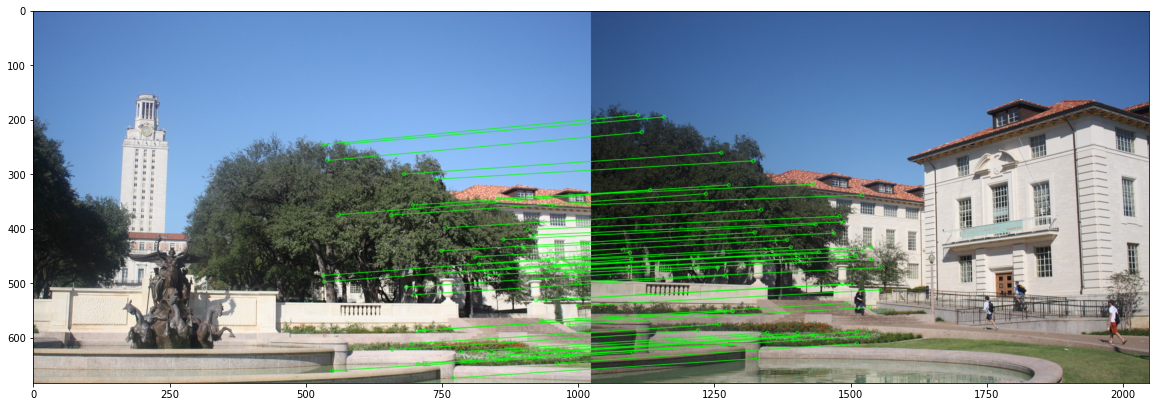

In [142]:
matches_50 = random.sample(matches, 50)

draw_params = dict(matchColor = (0,255,0), singlePointColor = None, flags = 2)
match_plot = cv2.drawMatches(image_src,kp_src,image_dst,kp_dest,matches_50,None,**draw_params)

plt.figure(figsize=(20, 20))
plt.imshow(match_plot)

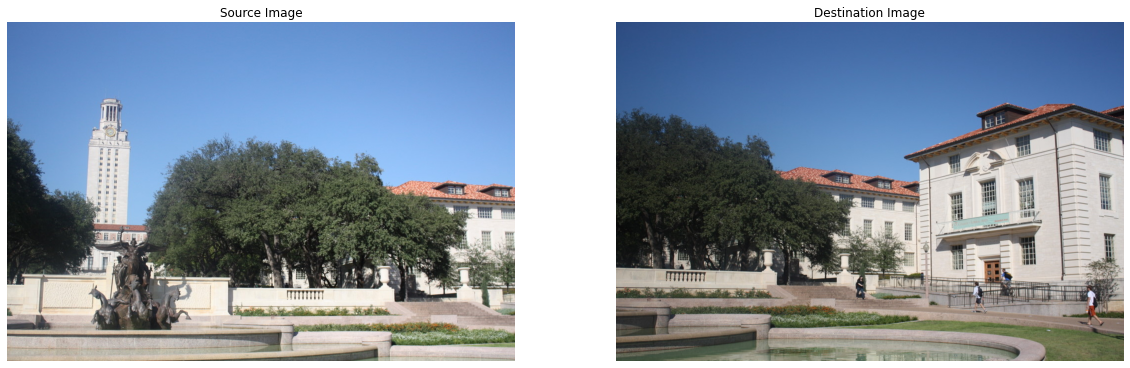

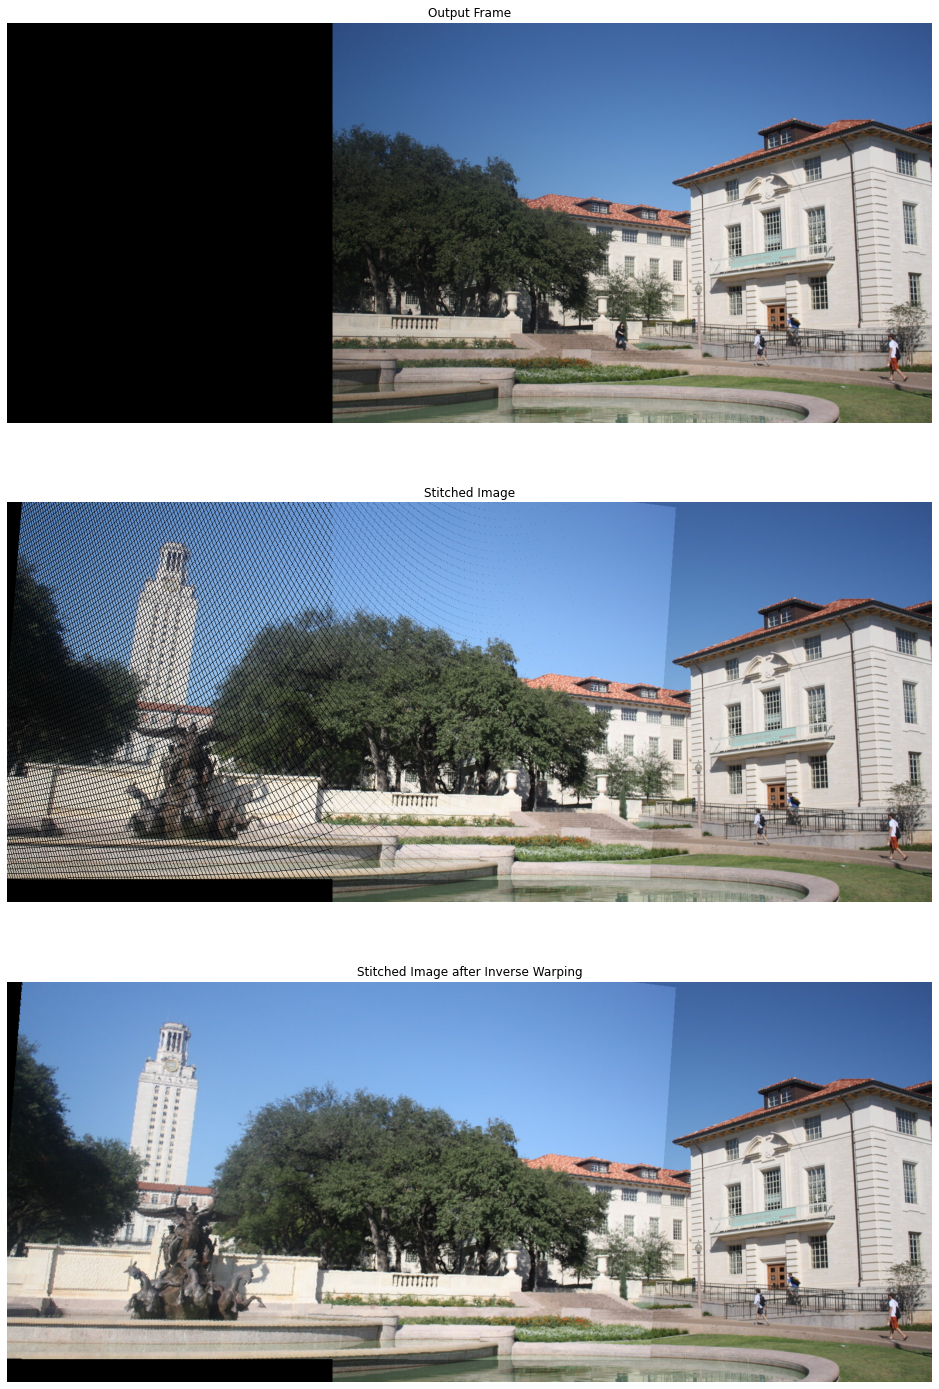

In [143]:
# Create output frame to hold stitched image
warp_frame = getWarpFrame(image_src=image_src, image_dst=image_dst, shift=max_x2)

# Warp source image into output frame
warped_image = warpImages(warp_frame=warp_frame, image_src=image_src, homography_mat=M1, shift=max_x2)

# Fix black pixels in warped image using reverse warping and interpolating source pixel values
stitched_image = invWarpInterpolation(warped_image=warped_image, image_src=image_src, homography_matInv=M1_inv, shift=max_x2)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_src); plt.axis('off')
plt.title('Source Image')

plt.subplot(1, 2, 2)
plt.imshow(image_dst); plt.axis('off')
plt.title('Destination Image')

plt.figure(figsize=(25, 25))
plt.subplot(3, 1, 1)
plt.imshow(warp_frame); plt.axis('off')
plt.title('Output Frame')

plt.subplot(3, 1, 2)
plt.imshow(warped_image); plt.axis('off')
plt.title('Stitched Image')

plt.subplot(3, 1, 3)
plt.imshow(stitched_image); plt.axis('off')
plt.title('Stitched Image after Inverse Warping');

